In [13]:
import os
os.chdir("/home/canyon/hackday-q2-2024-open-earth-foundation")
from src.utils import *
import censusdis.data as ced
import matplotlib.pyplot as plt
alber_eq_us = "EPSG:5070"

### Introduction to GeoSpatial Data

This hackday will involve linking different datasets on energy consumption/emissions to population and other statistics to disagregate state/national values to the city level. To do so, we will make use of several sources of geospatial data. This notebook will serve as an guide to working with geospatial data and introduce a key technique - areal interpolation - that we will use in the hackday analysis.

 #### What is geospatial data?


 Geospatial (spatial) data refers to any form of data that contains information about geographic locations. In our context, it's easiest to think of geospatial datasets as through the GeoDataFrame object provided by the package geopandas. These dataframes are much like any other tabular data - rows and colunms with values inside each cell - but augemented with a special column called geometry that contains spatial information. This column can contain points (e.g. locations of schools), linestrings (e.g. road networks), or polygons (e.g. national or subnational boundaries). Most or all of the data we will work with today contains polygon geometries. Below, we load a geodataframe containing the boundaries of each city in the US.

In [14]:
city_gdf = load_data_from_ts3("Geometries/US_city_geometries.geojson")
city_gdf.head()

,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name,locode,bbox_west,bbox_south,bbox_east,bbox_north,geometry
0,297390788,relation,111100,33.942879,-91.843467,boundary,administrative,16,0.389785,city,Star City,"Star City, Lincoln County, Arkansas, 71667, Un...",US 5ST,-91.864844,33.919132,-91.803695,33.963980,"POLYGON ((-91.86484 33.93014, -91.86043 33.930..."
1,299235226,relation,10055350,43.770085,-85.028359,boundary,administrative,14,0.441292,municipality,Coldwater Township,"Coldwater Township, Isabella County, Michigan,...",US CWA,-85.088808,43.726524,-84.968352,43.813799,"POLYGON ((-85.08881 43.81361, -85.08728 43.726..."
2,298586541,relation,10058790,43.612498,-85.502892,boundary,administrative,14,0.440956,municipality,Mecosta Township,"Mecosta Township, Mecosta County, Michigan, Un...",US UMQ,-85.562523,43.554844,-85.443313,43.642155,"POLYGON ((-85.56252 43.56750, -85.56250 43.563..."
3,298671096,relation,10058798,43.850459,-85.265396,boundary,administrative,14,0.440860,municipality,Evart Township,"Evart Township, Osceola County, Michigan, 4963...",US EV2,-85.324856,43.813821,-85.206074,43.900977,"POLYGON ((-85.32486 43.90098, -85.32437 43.814..."
4,299094929,relation,10060174,44.031112,-85.622706,boundary,administrative,14,0.440715,municipality,Ellsworth Township,"Ellsworth Township, Lake County, Michigan, Uni...",US EY5,-85.682663,43.988255,-85.562681,44.074797,"POLYGON ((-85.68266 44.07469, -85.68201 43.988..."


#### Case study: How many people live in Boston? 

Here we present a short case study in geospatial data analysis. Our cities dataset contains the bounds of Boston, but not any information about its population.

In [15]:
boston = city_gdf.query("place_id == 298131270")
boston

,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name,locode,bbox_west,bbox_south,bbox_east,bbox_north,geometry
11707,298131270,relation,2315704,42.355433,-71.060511,boundary,administrative,16,0.710251,city,Boston,"Boston, Suffolk County, Massachusetts, United ...",US BOS,-71.191244,42.227911,-70.804488,42.396977,"POLYGON ((-71.19124 42.28294, -71.19123 42.282..."


The gold standard source of population data in the United States is the US Census. We can access this data using the python package `censusdis`. The query below retreives the total population (ACS variable B01001_001E) in each Census Tract (a small-ish geographic division) in Suffolk County, MA - the county that countains Boston. You can use the website [CensusReporter](https://censusreporter.org/) to find the codes for other variables.

In [1]:
import censusdis.data as ced

DATASET = "acs/acs5"
YEAR = 2020
CENSUS_VARS = {"NAME" : "NAME",
               "B01001_001E" : "total_pop",
}

suffolk_tracts = ced.download(DATASET, YEAR, CENSUS_VARS, state= "25", county = "025",tract = "*", with_geometry=True).rename(CENSUS_VARS, axis = 1).to_crs(4326)
suffolk_tracts.head(3)

/nas/local/simscripts/canyon/.nest/canyon_nest/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
Warning 3: Cannot find header.dxf (GDAL_DATA is not defined)
Cannot find header.dxf (GDAL_DATA is not defined)


,STATE,COUNTY,TRACT,NAME,total_pop,geometry
0,25,025,000101,"Census Tract 1.01, Suffolk County, Massachusetts",2031,"POLYGON ((-71.13660 42.36016, -71.13627 42.360..."
1,25,025,000102,"Census Tract 1.02, Suffolk County, Massachusetts",3786,"POLYGON ((-71.16090 42.35863, -71.15399 42.359..."
2,25,025,000201,"Census Tract 2.01, Suffolk County, Massachusetts",4421,"POLYGON ((-71.16764 42.35379, -71.16502 42.353..."


Below we plot the tracts in Suffolk county and color them by population:

<Axes: >

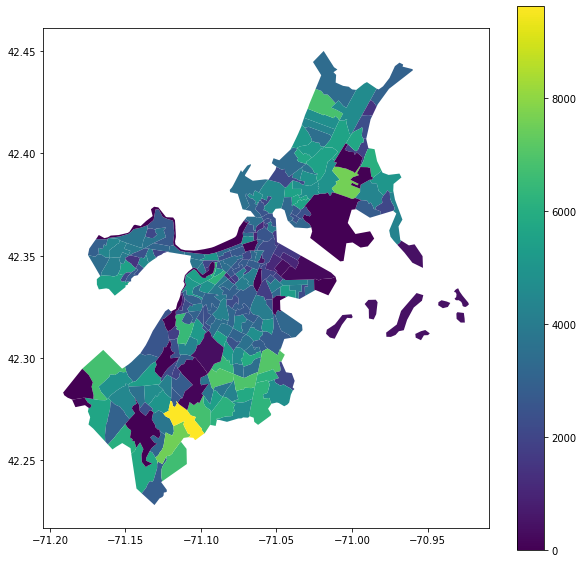

In [17]:
fig, ax = plt.subplots(figsize = (10,10))
suffolk_tracts.plot(column = "total_pop", ax = ax, legend=True)

We can identify the total population of Suffolk county easily - we just need to sum the values in each tract:

In [18]:
suffolk_tracts.total_pop.sum()

801162

However, this does not answer our original question. In the figure below, we can see that Boston (black outline) is mostly, but not entirely, coextensive with Suffolk county. In particular, the city limit is contained within the county, but it does not include the county's northern extent. 

We can use the geospatial properties of these data sets to address this and calculate the population of boston specifically.

<Axes: >

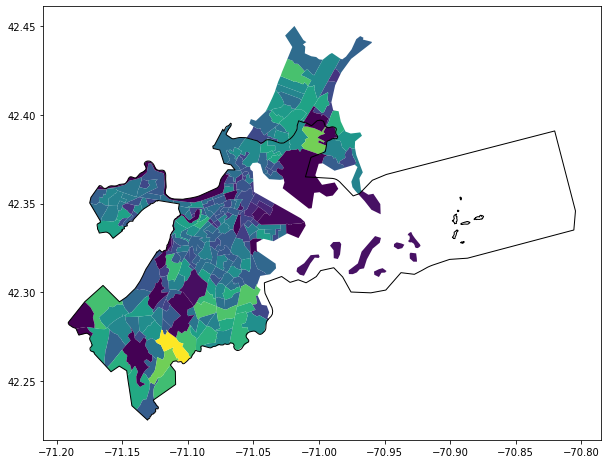

In [19]:
fig, ax = plt.subplots(figsize = (10,10))
suffolk_tracts.plot(column = "total_pop", ax = ax)
boston.plot(ax = ax, edgecolor='black', facecolor='none')

(The rectangular area extending east in the city bounds is in the Massachusetts Bay)

The simplest way to approach this problem is to identify the tracts that have any overlap with the city bounds and sum the population of those tracts. This can be accomplished with an `overlay` operation between the two datasets.

In [20]:
boston_tracts = gpd.sjoin(suffolk_tracts, boston, how = "inner", predicate = "intersects")

This takes us closer - we have removed the northern area of Suffolk county and our population estimate has been reduced:

In [21]:
boston_tracts.total_pop.sum()

723535

<Axes: >

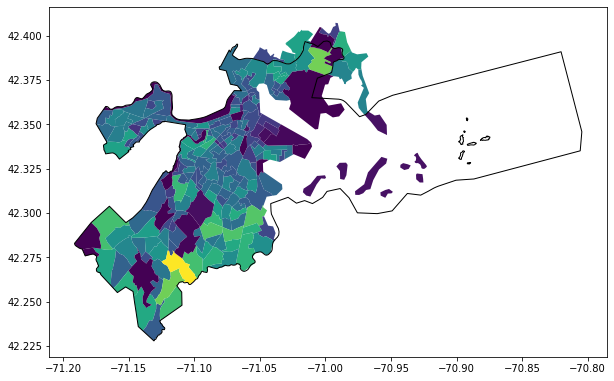

In [22]:
fig, ax = plt.subplots(figsize = (10,10))
boston_tracts.plot(column = "total_pop", ax = ax)
boston.plot(ax = ax, edgecolor='black', facecolor='none')

This can still be improved. Looking closely at the northern border, there are several tracts that are only partly contianed in the boston boundaries. Ideally, we'd only want these tracts to contribute only the portion of their population that is actually within the city. This brings us to the method of areal interpolation. If we make the assumption that population is evenly distributed across tracts, we can calculate the population contribution of each tract by multiplying the proportion of the tract contained in the city by the tract's population. For most tracts, this proportion will be 1.0 and the full population is taken into the estimate, but tracts with only partial overlap will contribute based on the degree of that overlap.

This method has 4 steps:

1. Calculate the area of each tract in Suffolk county
2. Perform an `overlap` operation that trims the Suffolk tracts to the bounds of Boston
3. Calculate the proportion of each tract inside the city bounds
4. Multiply these weights by tract populations

N.B. In order to calculate areas accurately, we must reproject the geospatial datasets into a 'planar' projection, in our case, the Albers US Equal Area projection (EPSG 5070).

In [23]:
boston = boston.to_crs(alber_eq_us)
suffolk_tracts = suffolk_tracts.to_crs(alber_eq_us)

Step 1:

In [24]:
suffolk_tracts["preclipped_area"] = suffolk_tracts.area

Step 2:

<Axes: >

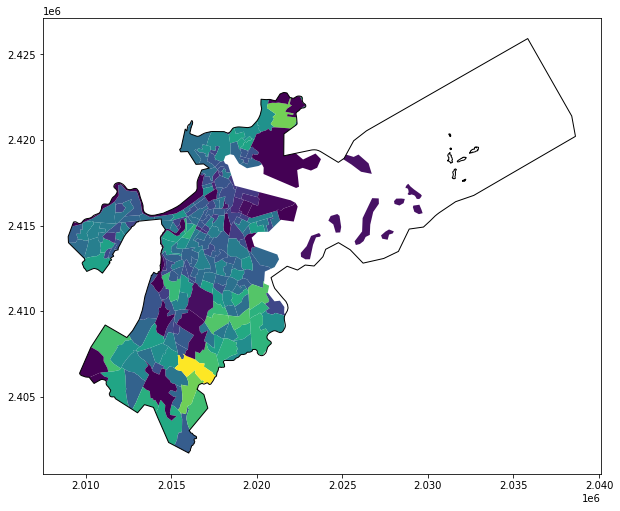

In [25]:
boston_clipped_tracts = boston.overlay(suffolk_tracts, how='intersection')
fig, ax = plt.subplots(figsize = (10,10))
boston_clipped_tracts.plot(column = "total_pop", ax = ax)
boston.plot(ax = ax, edgecolor='black', facecolor='none')

Step 3:

In [26]:
boston_clipped_tracts["area_proportion"] = boston_clipped_tracts.area / boston_clipped_tracts["preclipped_area"]

Step 4:

In [27]:
boston_clipped_tracts["interpolated_pop"] = boston_clipped_tracts["area_proportion"] * boston_clipped_tracts["total_pop"]

Now we have our final estimate:

In [28]:
boston_clipped_tracts.interpolated_pop.sum()

688495.2853457353

We can write a function that generalizes this process to aribtrary inputs:

In [34]:
def areal_interpolation(city_bounds, census_tracts, cols_to_interpolate, out_col_names, id_col = "place_id", planar_crs = "5070"):
    input_crs = city_bounds.crs

    city_bounds = city_bounds.to_crs(planar_crs).explode(index_parts=False) 
    city_bounds = city_bounds[city_bounds.geom_type == "Polygon"]
    census_tracts = census_tracts.to_crs(planar_crs)

    census_tracts["preclipped_area"] = census_tracts.area

    cities_clipped_tracts = city_bounds.overlay(census_tracts, how='intersection', keep_geom_type=False)
    cities_clipped_tracts["area_proportion"]  = cities_clipped_tracts.area / cities_clipped_tracts["preclipped_area"]
    for original_col, new_col in zip(cols_to_interpolate, out_col_names):
        cities_clipped_tracts[new_col] = cities_clipped_tracts[original_col] * cities_clipped_tracts["area_proportion"]
    
    city_interpolated_total = cities_clipped_tracts.groupby(id_col)[out_col_names].sum().reset_index()
    out = city_bounds.merge(city_interpolated_total)

    return out.to_crs(input_crs)

In the returned dataframe, we now have the new column `interpolated_city_pop` that contains this estimate. We can also pass in a dataframe with multiple cities, and/or interpolate multiple columns at once.

In [30]:
areal_interpolation(boston, suffolk_tracts, ["total_pop"], ["interpolated_city_pop"])

TypeError: GeoDataFrame.overlay() got an unexpected keyword argument 'use_sindex'

In [31]:
import censusdis.data as ced
from censusdis.states import ALL_STATES_AND_DC
DATASET = "acs/acs5"
YEAR = 2020
CENSUS_VARS = {"NAME" : "NAME",
               "B01001_001E" : "total_pop",
               "B25003_001E": "total_households",
               "B08201_002E" : "households_no_vehicle",
               "B08136_002E" : "travel_time_to_work_car_truck"

}

US_tracts = ced.download(DATASET, YEAR, CENSUS_VARS, state= ALL_STATES_AND_DC, county = "*",tract = "*", with_geometry=True).rename(CENSUS_VARS, axis = 1).to_crs(4326)

In [36]:
US_tracts.sample(10)

,STATE,COUNTY,TRACT,NAME,total_pop,total_households,households_no_vehicle,travel_time_to_work_car_truck,geometry
71097,48,041,001102,"Census Tract 11.02, Brazos County, Texas",1465,609,86,NaN,"POLYGON ((-96.33969 30.65005, -96.33577 30.652..."
11306,06,075,013002,"Census Tract 130.02, San Francisco County, Cal...",2755,1261,471,NaN,"POLYGON ((-122.43733 37.79781, -122.43568 37.7..."
2840,04,017,960500,"Census Tract 9605, Navajo County, Arizona",5221,1001,31,NaN,"POLYGON ((-110.75070 35.03157, -110.75069 35.0..."
66153,42,101,017400,"Census Tract 174, Philadelphia County, Pennsyl...",2570,914,374,NaN,"POLYGON ((-75.15399 39.99678, -75.15378 39.997..."
33840,22,071,003900,"Census Tract 39, Orleans Parish, Louisiana",1101,551,126,NaN,"POLYGON ((-90.07474 29.96220, -90.07334 29.963..."
68535,46,081,966101,"Census Tract 9661.01, Lawrence County, South D...",3550,1450,56,NaN,"POLYGON ((-103.86441 44.52006, -103.86425 44.5..."
63955,42,011,010304,"Census Tract 103.04, Berks County, Pennsylvania",6853,2101,27,NaN,"POLYGON ((-76.05154 40.38776, -76.05102 40.389..."
49850,36,005,003300,"Census Tract 33, Bronx County, New York",3140,1208,810,NaN,"POLYGON ((-73.91563 40.80970, -73.91518 40.810..."
52124,36,059,408400,"Census Tract 4084, Nassau County, New York",3899,1434,9,55405.0,"POLYGON ((-73.57595 40.69450, -73.57481 40.694..."
27595,17,141,961200,"Census Tract 9612, Ogle County, Illinois",6764,2588,132,NaN,"POLYGON ((-89.16958 41.93481, -89.15778 41.937..."


We can get the population of all cities in Massachusetts like this:

In [33]:
US_interpolated = areal_interpolation(city_gdf, US_tracts, ["total_pop", "total_households"], ["interpolated_city_pop", "interpolated_households"])

TypeError: GeoDataFrame.overlay() got an unexpected keyword argument 'use_sindex'

In [20]:
mass_full = mass_tracts.unary_union
mass_cities = city_gdf[city_gdf.centroid.apply(lambda x: x.within(mass_full))]

mass_interpolated = areal_interpolation(mass_cities, mass_tracts, ["total_pop", "total_households"], ["interpolated_city_pop", "interpolated_households"])
mass_interpolated.head(5)

/tmp/ipykernel_1327389/2413123547.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mass_cities = city_gdf[city_gdf.centroid.apply(lambda x: x.within(mass_full))]


,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name,locode,bbox_west,bbox_south,bbox_east,bbox_north,geometry,interpolated_city_pop,interpolated_households
0,297882289,relation,1181602,42.067095,-72.861165,boundary,administrative,16,0.296083,town,Granville,"Granville, Hampden County, Massachusetts, 0103...",US VL4,-72.981906,42.037079,-72.832406,42.136694,"POLYGON ((-72.98191 42.13669, -72.97033 42.078...",2339.531976,914.534047
1,297915961,relation,1181605,42.186736,-72.952707,boundary,administrative,16,0.335695,town,Blandford,"Blandford, Hampden County, Massachusetts, 0100...",US FB8,-73.034920,42.123918,-72.872183,42.251347,"POLYGON ((-73.03492 42.14365, -73.03431 42.143...",1322.517877,518.958899
2,297908046,relation,1181607,42.103088,-72.318940,boundary,administrative,16,0.317252,town,Monson,"Monson, Hampden County, Massachusetts, 01057, ...",US MZS,-72.389031,42.031615,-72.270096,42.161702,"POLYGON ((-72.38903 42.15234, -72.37944 42.103...",8784.369018,3562.542206
3,297317632,relation,1181608,42.125204,-72.200568,boundary,administrative,16,0.305004,town,Brimfield,"Brimfield, Hampden County, Massachusetts, 0101...",US BF5,-72.274455,42.090665,-72.135011,42.183831,"POLYGON ((-72.27446 42.14375, -72.27445 42.143...",3664.488798,1494.576904
4,298060944,relation,1181609,42.148769,-72.607112,boundary,administrative,16,0.468922,city,Chicopee,"Chicopee, Hampden County, Massachusetts, Unite...",US CEF,-72.628629,42.123771,-72.513909,42.218732,"POLYGON ((-72.62863 42.16766, -72.62861 42.166...",55152.811510,23433.143697
